In [ ]:
import torch
import torchvision.utils as utils
import matplotlib.pyplot as plt
from dcgan import DCGAN

# Latent space interpolation

In [15]:
lightning_checkpoint = torch.load(
    "../checkpoints/dcgan/dcgan-transforms-epoch=134-d_loss=0.06-g_loss=4.11-fid_score=66.50.ckpt",
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = DCGAN.load_from_checkpoint(
    "../checkpoints/dcgan/dcgan-transforms-epoch=134-d_loss=0.06-g_loss=4.11-fid_score=66.50.ckpt",
    **hyperparams,
)

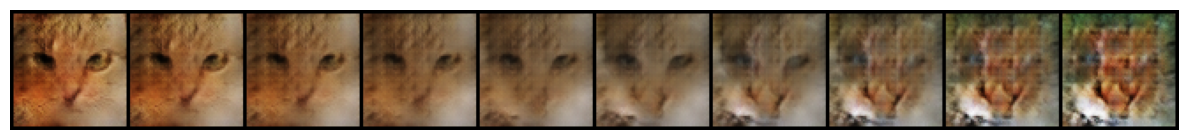

In [ ]:
num_steps = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
z1 = torch.randn(1, hyperparams["latent_dim"], device=device)
z2 = torch.randn(1, hyperparams["latent_dim"], device=device)
alphas = torch.linspace(0, 1, steps=num_steps, device=device).unsqueeze(1)
zs = (1 - alphas) * z1 + alphas * z2
with torch.no_grad():
    imgs = model.generator(zs)
    imgs = (imgs + 1) / 2
    imgs = torch.clamp(imgs, 0, 1)
grid = utils.make_grid(imgs, nrow=num_steps, padding=2)
np_grid = grid.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(num_steps * 1.5, 1.5))
plt.axis("off")
plt.imshow(np_grid)
plt.tight_layout()
plt.show()

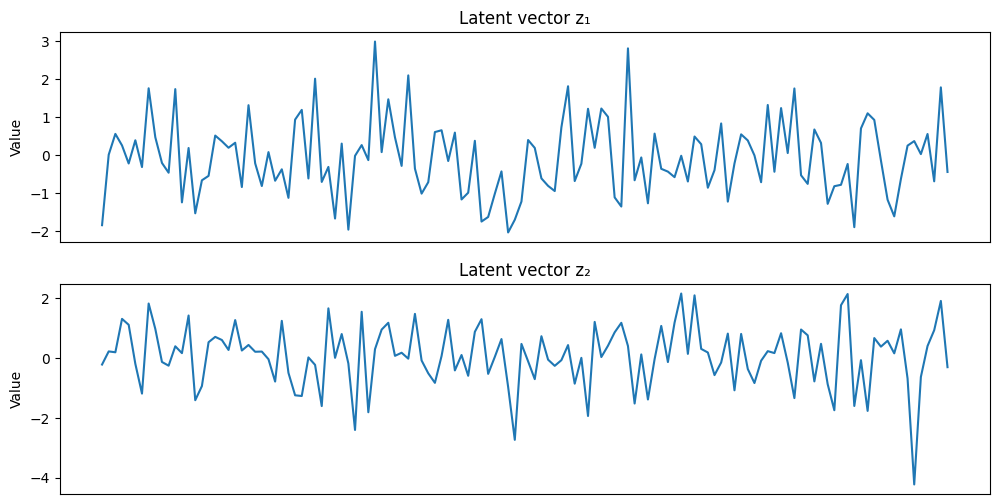

In [ ]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(num_steps * 1.2, 6),
)
axes[0].plot(z1.cpu().squeeze().numpy())
axes[0].set_title("Latent vector z₁")
axes[0].set_ylabel("Value")
axes[0].set_xticks([])
axes[1].plot(z2.cpu().squeeze().numpy())
axes[1].set_title("Latent vector z₂")
axes[1].set_ylabel("Value")
axes[1].set_xticks([])
plt.show()